<a href="https://colab.research.google.com/github/analystanand/nlp_transfer_learning/blob/master/Quora_Insincere_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install transformers

In [0]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel,BertForSequenceClassification,AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [0]:
# Set the maximum sequence length.
MAX_LEN = 128

In [0]:
all_test = pd.read_csv("/content/test.csv")
all_train = pd.read_csv("/content/train.csv")

In [0]:
#Roughly Estimates Max Length of Sentences
# all_train["split_sentences"] = all_train['question_text'].apply(lambda x: len(x.split()))

In [19]:
all_train.shape

(1306122, 3)

In [0]:
sample_train =  all_train.loc[:1999,:]
evaluation_df = all_train.loc[2000:3999,:]

In [65]:
print("Train Size:",sample_train.shape,"Test Size:",evaluation_df.shape)

Train Size: (2000, 3) Test Size: (2000, 3)


In [66]:
sample_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [67]:
sample_test.head()

,qid,question_text,target
2000,0063a1a34251bd6ff6e1,Do you know anyone from LNMIIT who has given S...,0
2001,0063b44a0b7d32c7657c,What is an open area in the centre of a buildi...,0
2002,0063b684ac85062aa6c6,I said modern life is better than ancient?,0
2003,0063c89a5fc8582b0cd4,Which is the amusing app for downloading free ...,0
2004,0063d9121d52fedc9994,What clothing starts with r?,0


In [0]:
#creates list of sentences and labels
sentences = sample_train.question_text.values
labels = sample_train.target.values


In [25]:
#initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 937889.61B/s]


In [0]:
#user tokenizer to convert sentences into tokenizer
input_ids  = [tokenizer.encode(sent,add_special_tokens=True,max_length=MAX_LEN) for sent in sentences]

In [0]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [28]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)
print(attention_masks[5])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## Train and Validation Split

In [0]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:

# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

##Train Model

In [32]:

# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

100%|██████████| 440473133/440473133 [00:16<00:00, 27125498.73B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [0]:
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=10e-8)

In [0]:

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [37]:

# # Store our loss and accuracy for plotting
train_loss_set = []

# # Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    # loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    outputs = model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs =  model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      loss, logits = outputs[:2]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.17075863038807843


Epoch:  33%|███▎      | 1/3 [00:27<00:55, 27.80s/it]

Validation Accuracy: 0.9182692307692307
Train loss: 0.10741481816280732


Epoch:  67%|██████▋   | 2/3 [00:55<00:27, 27.78s/it]

Validation Accuracy: 0.9471153846153846
Train loss: 0.044070811266392736


Epoch: 100%|██████████| 3/3 [01:23<00:00, 27.77s/it]

Validation Accuracy: 0.9134615384615384


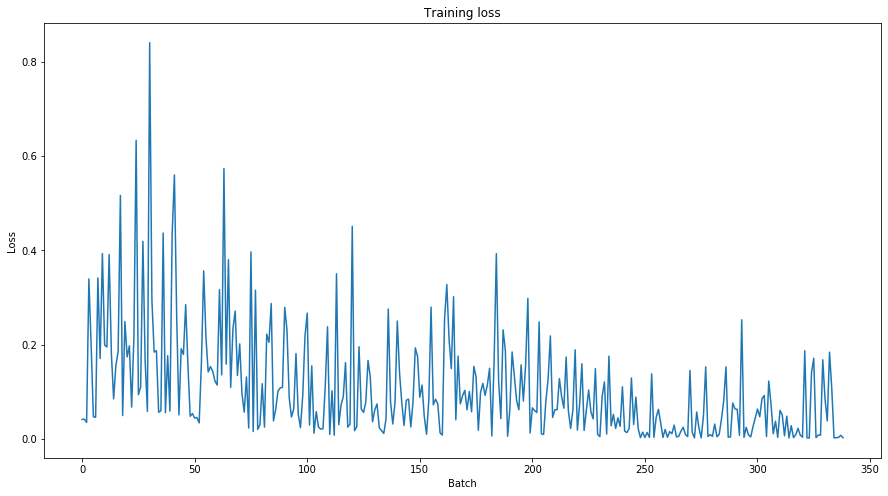

In [38]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()



###Data Tranformation For Evaluation

In [0]:
#creates list of sentences and labels
sentences = evaluation_df.question_text.values
qids = evaluation_df.qid.values
labels = evaluation_df.target.values

#user tokenizer to convert sentences into tokenizer
input_ids  = [tokenizer.encode(sent,add_special_tokens=True,max_length=MAX_LEN) for sent in sentences]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 16 


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Evaluation of Model

In [78]:
# Prediction on evaluation set

# Put model in evaluation mode
model.eval()
test_accuracy = 0
# Tracking variables 
predictions , true_labels = [], []
flat_pred = []
flat_true_label =[]
nb_test_steps = 0
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs =  model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss, logits = outputs[:2]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  nb_test_steps += 1
  
  # Store predictions and true labels
  predictions.append(logits)
  flat_pred.extend(np.argmax(logits, axis=1).flatten())
  true_labels.append(label_ids)
  # print(label_ids)
  flat_true_label.extend(label_ids)
  test_eval_accuracy = flat_accuracy(logits, label_ids)
  test_accuracy += tmp_eval_accuracy

print("Evaluation Accuracy: {}".format(test_accuracy/nb_test_steps))

Evaluation Accuracy: 0.75


In [79]:
len(flat_pred)

2000

In [80]:
len(flat_true_label)

2000

In [81]:
for index,sent,t_label,pred_label in zip(qids[:SAMPLE],sentences[:SAMPLE],flat_true_label[:SAMPLE],flat_pred[:SAMPLE]):
    print(index,sent,t_label,pred_label)

0063a1a34251bd6ff6e1 Do you know anyone from LNMIIT who has given SSC exam and succeeded? 0 0
0063b44a0b7d32c7657c What is an open area in the centre of a building called? It has staircases on the side, maybe also an elevator but the centre is open all the way to the top and is surrounded by parapet walls. 0 0
0063b684ac85062aa6c6 I said modern life is better than ancient? 0 0
0063c89a5fc8582b0cd4 Which is the amusing app for downloading free Arabic video songs? 0 0
0063d9121d52fedc9994 What clothing starts with r? 0 0
0063ea3162cc2a5dfadb How are Flag hoist? 0 0
00640861dd78fdc0abe5 What can I do if I know I'm being observed and I'm being provoked into a reaction? 0 0
00640ca487e82ccdc69b Should I go to UCSB or UCSD for film? 0 0
00641b646d4859b8afeb Can the ambassador from Venezuela mind sending a postcard to a postcard collector in India? 0 0
00642afbfe7bf2077e56 What challenges did Joseph Gordon-Levitt face in order to become an actor? 0 0


In [0]:
pred_df = pd.DataFrame(columns=["qid","prediction"])
pred_df["qid"] = qids
pred_df["prediction"]  = pred_label

In [83]:
pred_df.shape

(2000, 2)

##Data Transformation for Testing Set

In [0]:
#creates list of sentences and labels
sentences = all_test.question_text.values
qids = all_test.qid.values

#user tokenizer to convert sentences into tokenizer
input_ids  = [tokenizer.encode(sent,add_special_tokens=True,max_length=MAX_LEN) for sent in sentences]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)

batch_size = 16 


prediction_data = TensorDataset(prediction_inputs, prediction_masks,)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Predicting on Test Set

In [0]:
# Prediction on testing set
model.eval()
flat_pred = []
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs =  model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy() 
    flat_pred.extend(np.argmax(logits, axis=1).flatten())

In [0]:
len(flat_pred)

In [0]:
pred_df = pd.DataFrame(columns=["qid","prediction"])
pred_df["qid"] = qids
pred_df["prediction"]  = flat_pred